## 실제 데이터를 활용해서 분석해보기

전기요금 예측하기 


공공데이터 포털에서 전기요금 시뮬레이터 api를 활용해서 데이터 획득

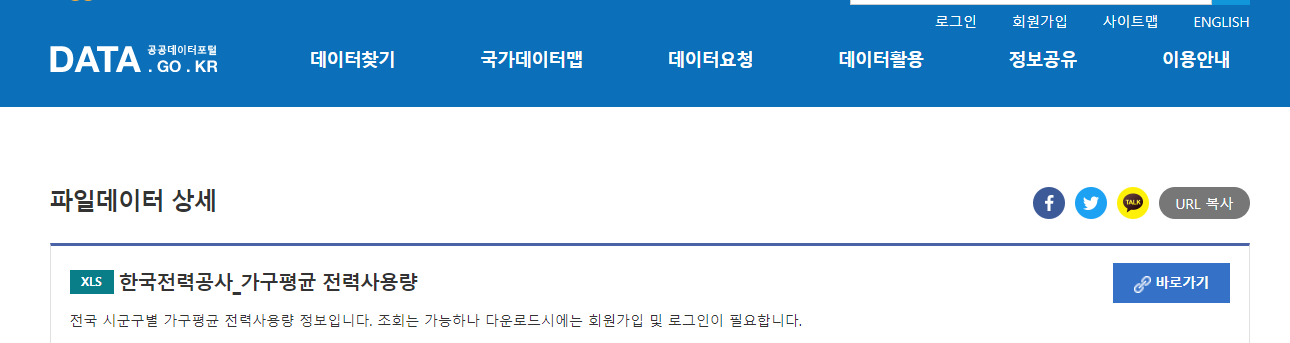

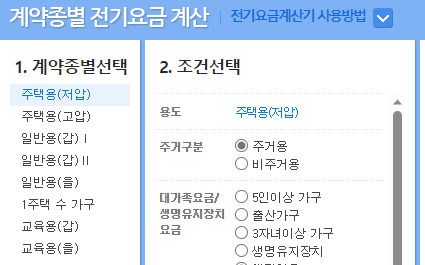


송파구 4월 가구별 전력사용량 을 api 를 활용해서 시뮬레이션 돌린 데이터를 활용
2023_04.csv 파일

In [2]:
# 필수 라이브러리 로드 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("2023_04_.csv")

In [4]:
df

,Unnamed: 0,사용량,장애인 및 상이유공자,기초생활수급자,차상위계층,3자녀 이상가구,출산 가구,생명유지장치 사용고객,전기요금(저압)
0,0,311.483714,yes,no,no,no,yes,no,53885
1,1,299.188761,no,no,no,no,no,no,51075
2,2,498.483563,no,no,no,no,no,no,111463
3,3,306.006093,no,no,no,no,no,no,52633
4,4,166.695383,no,no,no,no,yes,no,23247
...,...,...,...,...,...,...,...,...,...
104941,104941,312.085621,no,no,no,no,no,no,54023
104942,104942,347.500105,no,no,no,no,no,no,62119
104943,104943,292.615336,no,no,no,no,yes,no,49572
104944,104944,79.234734,no,no,no,no,no,no,11527


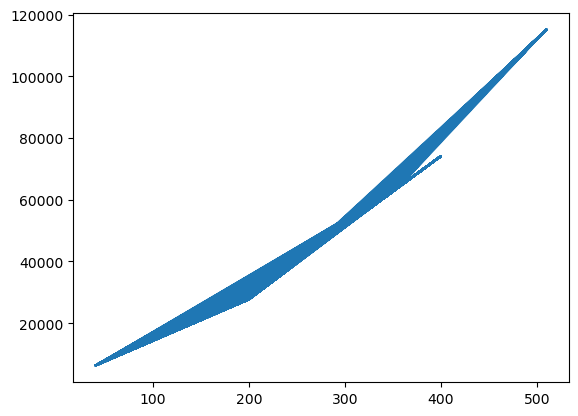

In [5]:
plt.plot(df['사용량'], df['전기요금(저압)'])

- 일반적으로 전력사용량(x축) 과 전기요금(y축) 은 비례하는데 기울기가 살짝 다름 (누진요금)
- 200~400 구간에 같은 사용량이더라도 다른 금액을 내는 경우 있음 -> 가족 구성원에 따른 할인 요금 차이

실제로는 계산식이 되게 복잡하다 -> 이걸 모델링하는건 쉽지 않음 (목표 1% 이내로 맞추어보자!)

먼저 문자열은 다루기 힘들기 때문에 (모델에 넣기위해서) yes, no 를 1, 0 으로 각각 맵핑해준다.
이걸 categorical 데이터를 numeric 하게 만든다고 표현함

In [6]:
mapping_code = { "yes":1, "no":0}

for icol in df.columns[2:-1]:
    df[icol] = df[icol].map(mapping_code)

df 
## 또는 심플하게 df.replace("yes", 1).replace("no", 0)

,Unnamed: 0,사용량,장애인 및 상이유공자,기초생활수급자,차상위계층,3자녀 이상가구,출산 가구,생명유지장치 사용고객,전기요금(저압)
0,0,311.483714,1,0,0,0,1,0,53885
1,1,299.188761,0,0,0,0,0,0,51075
2,2,498.483563,0,0,0,0,0,0,111463
3,3,306.006093,0,0,0,0,0,0,52633
4,4,166.695383,0,0,0,0,1,0,23247
...,...,...,...,...,...,...,...,...,...
104941,104941,312.085621,0,0,0,0,0,0,54023
104942,104942,347.500105,0,0,0,0,0,0,62119
104943,104943,292.615336,0,0,0,0,1,0,49572
104944,104944,79.234734,0,0,0,0,0,0,11527


가장 기본적인 모델링은 사용량과 전기요금을 선형 회귀 해보는 것임 (Null 모델)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error 

linear_model = LinearRegression()

In [8]:
x = df["사용량"]
y = df["전기요금(저압)"]

x = np.array(x)
y = np.array(y)

x= x.reshape(-1, 1)
y= y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

In [9]:
linear_model.fit(X=X_train, y=y_train)

LinearRegression()

In [10]:
predicted_y = linear_model.predict(X_test)

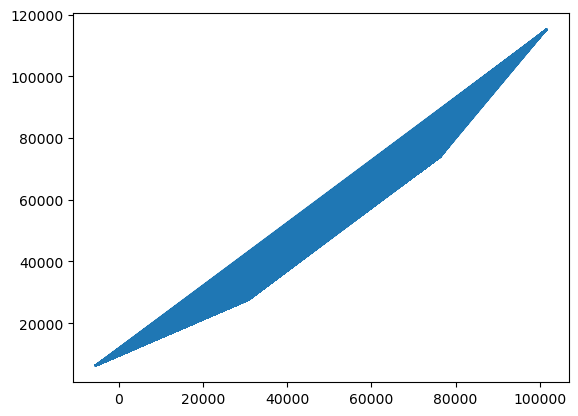

In [11]:
plt.plot( predicted_y, y_test)

In [12]:
mean_absolute_percentage_error(predicted_y, y_test)

0.7698819949973771

단순 사용량~요금의 선형 회귀만으로도 대략적으로 잘 예측이된다. (사실 비슷하니) 이 경우 평균 3580원 정도의 Error 가 발생하는데, 이걸 딥러닝 모델로 구현해보자

In [28]:

x = df["사용량"]
y = df["전기요금(저압)"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

In [29]:
model = tf.keras.Sequential()

model.add( tf.keras.layers.Input( 1 ))
model.add( tf.keras.layers.Dense( 10 ))
model.add( tf.keras.layers.Dense( 10 ))
model.add( tf.keras.layers.Dense( 1) )
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                20        
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 141 (564.00 Byte)
Trainable params: 141 (564.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


무려 141개의 parameter를 가진 모델을 구현했다.  이제 이걸 컴파일해서 학습을 시켜보자 (손실함수는 mean squre error, 옵티마이저는 모르면 adam 이라고 했다.)

In [30]:
model.compile(optimizer='adam',  loss='mse' ) 
model.fit(x = X_train, y= y_train, epochs=15 )

Epoch 1/15
656/656 [==============================] - 0s 435us/step - loss: 1931182336.0000
Epoch 2/15
656/656 [==============================] - 0s 419us/step - loss: 53191888.0000
Epoch 3/15
656/656 [==============================] - 0s 417us/step - loss: 42106472.0000
Epoch 4/15
656/656 [==============================] - 0s 422us/step - loss: 42022928.0000
Epoch 5/15
656/656 [==============================] - 0s 520us/step - loss: 41932432.0000
Epoch 6/15
656/656 [==============================] - 0s 428us/step - loss: 41762056.0000
Epoch 7/15
656/656 [==============================] - 0s 417us/step - loss: 41588892.0000
Epoch 8/15
656/656 [==============================] - 0s 419us/step - loss: 41402772.0000
Epoch 9/15
656/656 [==============================] - 0s 412us/step - loss: 41193560.0000
Epoch 10/15
656/656 [==============================] - 0s 427us/step - loss: 40979144.0000
Epoch 11/15
656/656 [==============================] - 0s 416us/step - loss: 40789996.0000
Epoch 

2624/2624 [==============================] - 1s 327us/step


0.10129525132490347

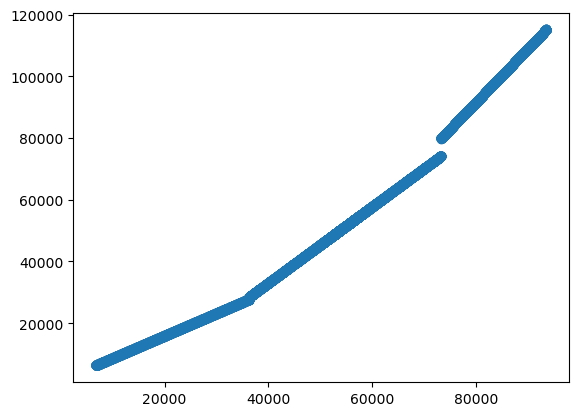

In [31]:
predicted_y = model.predict( X_test )
plt.scatter( predicted_y, y_test )
mean_absolute_percentage_error(predicted_y, y_test)

단순 모델로 돌려도 (선형임을 가정하는 일 따위 필요없이) 선형회귀와 비슷한 수준의 결과가 나온다. 

## 이제 좀 더 많은 input 을 넣어보자

In [19]:

x = df.iloc[:,1:-1].to_numpy()
y = df["전기요금(저압)"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)


In [21]:
model2 = tf.keras.Sequential()

model2.add( tf.keras.layers.Input( 7 ))
model2.add( tf.keras.layers.Dense( 35))
model2.add( tf.keras.layers.Dense( 20 ))
model2.add( tf.keras.layers.Dense( 1) )

모델에 인풋이 7개나 더들어가기 때문에 사이즈도 좀 더 키워줬다. 

In [22]:
model2.compile(optimizer='adam',  loss='mse' )
model2.fit(x = X_train, y= y_train, epochs=15 )

Epoch 1/15
656/656 [==============================] - 0s 497us/step - loss: 1022856448.0000
Epoch 2/15
656/656 [==============================] - 0s 489us/step - loss: 42947412.0000
Epoch 3/15
656/656 [==============================] - 0s 486us/step - loss: 42736244.0000
Epoch 4/15
656/656 [==============================] - 0s 483us/step - loss: 42443540.0000
Epoch 5/15
656/656 [==============================] - 0s 485us/step - loss: 42063816.0000
Epoch 6/15
656/656 [==============================] - 0s 481us/step - loss: 41649844.0000
Epoch 7/15
656/656 [==============================] - 0s 519us/step - loss: 41197948.0000
Epoch 8/15
656/656 [==============================] - 0s 480us/step - loss: 40693060.0000
Epoch 9/15
656/656 [==============================] - 0s 490us/step - loss: 40187376.0000
Epoch 10/15
656/656 [==============================] - 0s 502us/step - loss: 39647668.0000
Epoch 11/15
656/656 [==============================] - 0s 481us/step - loss: 39165812.0000
Epoch 

2624/2624 [==============================] - 1s 325us/step


0.09491530731938043

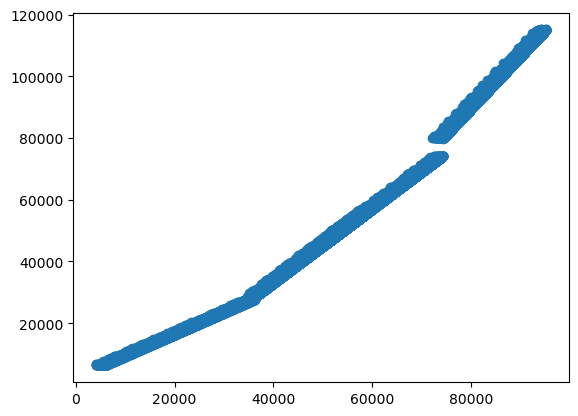

In [23]:
predicted_y = model2.predict( X_test )
plt.scatter( predicted_y, y_test )
mean_absolute_percentage_error(predicted_y, y_test)

뭔가 할인을 적당히 계산해서 실제와 예상의 경향은 비슷하게 나왔지만 error 는 오히려 살짝 커졌다. 이는 할인에 관련된 factor 의 스케일(0~1)과 전력 사용량 (~500 kW) 의 스케일이 전혀 다르기 때문에 신경망 weight 가 한쪽만 바라보기 때문이다. 이를 해결하기 위해 들어가는 input의 크기를 비슷하게 맞춰주는 scaling 작업을 해준다. 모양의 변화는 전혀 없이 단순히 상수로 나눠주고 더해줘서 min-max 를 0~1 로 맞추는 min-max scaling  을 진행한다.

In [32]:


x = df.iloc[:,1:-1].to_numpy()
x[:, 0] = (x[:,0] - min(x[:,0])) / (max(x[:,0]) - min(x[:,0]))
y = df["전기요금(저압)"]


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

그리고 할인 항목의 경우 O, X 의 역활이 크기 때문에, relu 보다는 0, 1 로 boundary를 정해주는 sigmoid 또는 tanh 같은 비선형 함수를 추가해준다.

In [190]:
model3 = tf.keras.Sequential()

model3.add( tf.keras.layers.Input( 7 ))
model3.add( tf.keras.layers.Dense( 200 , activation='tanh'))
model3.add( tf.keras.layers.BatchNormalization())
model3.add( tf.keras.layers.Dropout(0.1))
model3.add( tf.keras.layers.Dense( 200 , activation='sigmoid' ))
model3.add( tf.keras.layers.BatchNormalization())

model3.add( tf.keras.layers.Dense( 64 ))

model3.add( tf.keras.layers.Dense( 1) )


model3.compile(optimizer='adam',  loss='mse')
model3.fit(x = X_train, y= y_train, epochs=15 )

Epoch 1/15
656/656 [==============================] - 1s 1ms/step - loss: 2403135232.0000
Epoch 2/15
656/656 [==============================] - 1s 1ms/step - loss: 280292128.0000
Epoch 3/15
656/656 [==============================] - 1s 1ms/step - loss: 23092824.0000
Epoch 4/15
656/656 [==============================] - 1s 1ms/step - loss: 21443268.0000
Epoch 5/15
656/656 [==============================] - 1s 1ms/step - loss: 18704492.0000
Epoch 6/15
656/656 [==============================] - 1s 1ms/step - loss: 22147930.0000
Epoch 7/15
656/656 [==============================] - 1s 1ms/step - loss: 19963330.0000
Epoch 8/15
656/656 [==============================] - 1s 1ms/step - loss: 19013850.0000
Epoch 9/15
656/656 [==============================] - 1s 1ms/step - loss: 19696474.0000
Epoch 10/15
656/656 [==============================] - 1s 1ms/step - loss: 21753728.0000
Epoch 11/15
656/656 [==============================] - 1s 1ms/step - loss: 19307220.0000
Epoch 12/15
656/656 [======

2624/2624 [==============================] - 1s 448us/step


0.01675540484592346

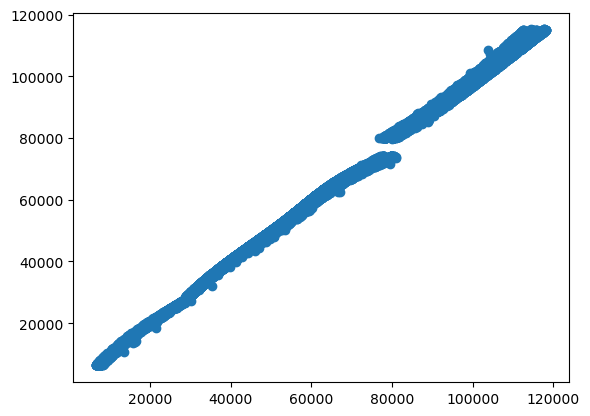

In [191]:
predicted_y = model3.predict( X_test )
plt.scatter( predicted_y, y_test )
mean_absolute_percentage_error(predicted_y, y_test)

이제 별다른 할인에 대한 공식이나, 가정을 하나도 지정하지 않고, 단순히 충분히 복잡한 네트워크를 설계하는 것만으로도, 중증장애인 할인, 다가족 할인, 자녀할인, 누진제에 따른 기본요금 변동과 누진 전기료를 거의 흡사하게 맞춤을 알 수 있다.